# Examen Integrador
<br/>

## Curso de Especialización en Inteligencia Artificial
## Introducción a la Inteligencia Artificial
<br/>

### Autor: Maximiliano Torti
### Fecha: 17/06/21
<br/>


In [1]:
import numpy as np

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20

## Apartado 2

In [4]:
class Data(object):

    dataset=None
    

    def __init__(self, path):
        self.dataset = self._build_dataset(path)

    def _build_dataset(self, path):
        structure = [('x', np.float64),
                     ('y', np.float64)]

        with open(path, encoding="utf8") as data_csv:
            data_gen = ((float(line.split(',')[0]), float(line.split(',')[1]))
                        for i, line in enumerate(data_csv))
            embeddings = np.fromiter(data_gen, structure)

        return embeddings
    
    def split_train_test(self, pct_test):
        X = self.dataset['x']
        y = self.dataset['y']

        permuted_idxs = np.random.permutation(X.shape[0])

        test_idxs = permuted_idxs[0:int(pct_test * X.shape[0])]
        

        train_idxs = permuted_idxs[int(pct_test * X.shape[0]): X.shape[0]]

        X_train = X[train_idxs]
        X_test = X[test_idxs]

        y_train = y[train_idxs]
        y_test = y[test_idxs]

        return X_train, X_test, y_train, y_test

In [5]:
# Cargo el dataset
dataset = Data ('./clase_8_dataset.csv')

Text(0, 0.5, 'y')

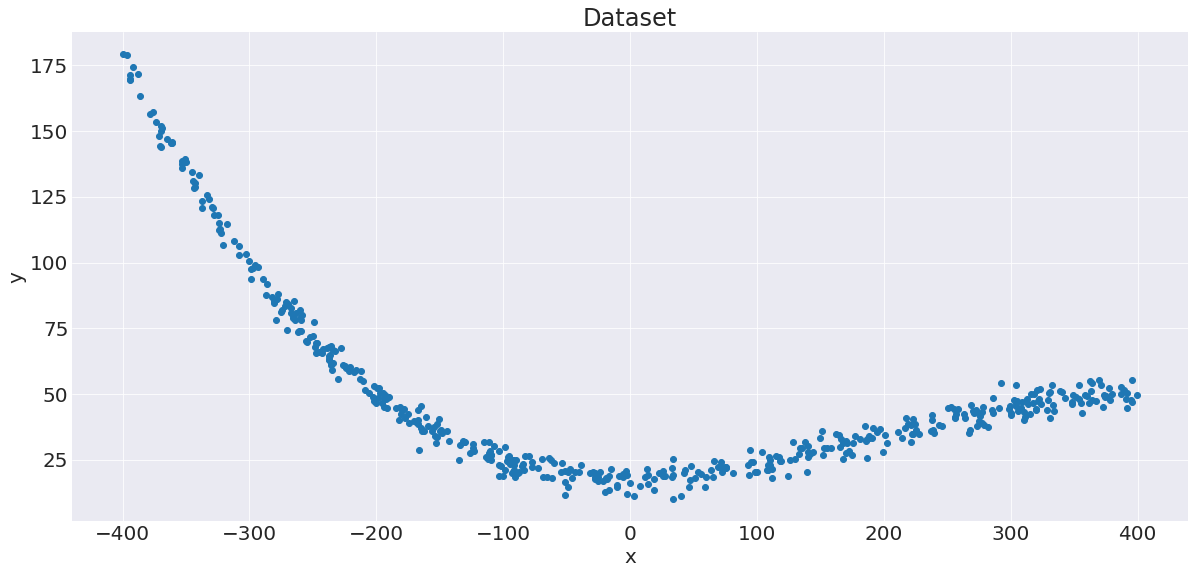

In [10]:
# Plot nube de puntos del dataset
plt.figure()
plt.scatter(dataset.dataset['x'],dataset.dataset['y'])
plt.title('Dataset')
plt.xlabel('x')
plt.ylabel('y')

In [12]:
print(dataset.dataset['x'].shape)
print(dataset.dataset['y'].shape)

(500,)
(500,)


In [14]:
# Particiono el dataset y compruebo las dimensiones
X_train, X_test, y_train, y_test = dataset.split_train_test(0.2)
print(X_train.shape)
print(X_test.shape)

(400,)
(100,)


## Apartado 3

In [17]:
class BaseModel():
    """
    Base class for models
    """
    def __init__(self):
        pass
    
    def fit(self, X, y):
        return NotImplemented
    
    def transform(self,X):
        return NotImplemented
    
    def fit_transform(self, X, y):
        return NotImplemented
    
    def predict(self, X):
        return NotImplemented

In [18]:
class PolinomicRegressionModel(BaseModel):
    
    def __init__(self):
        pass
    
    def fit(self, X, y, deg=1, bias=True):

        if len(X.shape)<2:
            X=X[:,np.newaxis]
            
        X_aux = X.copy()
        for i in range(2,deg+1):
            X=np.hstack([X,X_aux**i])
            
        if bias:
            X=np.append(X, np.ones(shape=(X.shape[0],1)), axis = 1)
            
        y=y[:,np.newaxis]
        self.model= np.linalg.inv(np.transpose(X)@X)@np.transpose(X)@y
        self.bias = bias
        self.deg=deg
    
    def predict(self,X):

        if len(X.shape)<2:
            X=X[:,np.newaxis]
            
        X_aux = X.copy()
        for i in range(2,self.deg+1):
            X=np.hstack([X,X_aux**i])

        if self.bias:
            X=np.append(X, np.ones(shape=(X.shape[0],1)), axis = 1)
            
        y=X@self.model
        return y[:,0]

In [19]:
class BaseMetric:
    """
    Clase base métricas
    """
    def __init__(self):
        pass

    def __call__(self,truth, predicted):
        return NotImplemented

In [20]:
class MSE(BaseMetric):
    """
    Metrica MSE
    """
    def __init__(self):
        pass

    def __call__(self,truth, predicted):
        """
        Calculo de MSE
        
        Args:
            truth (numpy array): array de valores verdaderos
            predicted (numpy array): array de valores predichos

        Returns
            float: error cuadrático medio

        """
        mse= np.sum(np.power((predicted - truth),2))/ predicted.shape[0]
        return mse

In [48]:
def kfolds(X, y, k):
    
    folds = []
    chunk_size = round(X.shape[0] / k)
    for i in range(0, X.shape[0], chunk_size):
        end = i + chunk_size if i + chunk_size <= X.shape[0] else X.shape[0]
        x_valid = X[i: end]
        y_valid = y[i: end]
        x_train = np.concatenate([X[: i], X[end:]])
        y_train = np.concatenate([y[: i], y[end:]])
        
        folds.append((x_train,y_train,x_valid,y_valid))

    return folds

 Usando K-Folds, entrenamos diferentes modelos para n = 1. Como en este caso no tenemos un hiperparámetro para variar, simplemente seleccionaremos el modelo que mejor performa sobre la división de datos realizadas. En específico, seleccionamos aquel que tiene menor MSE en los datos de validación.

In [74]:
mse = MSE()

models=[]
train_error=[]
valid_error=[]

folds = kfolds (X_train, y_train, 5)

for (x_train_fold, y_train_fold, x_valid_fold, y_valid_fold) in folds:
    model_n1 = PolinomicRegressionModel()
    model_n1.fit(x_train_fold,y_train_fold)
    y_train_predicted = model_n1.predict(x_train_fold)
    y_valid_predicted = model_n1.predict(x_valid_fold)
    models.append(model_n1)
    train_error.append(mse(y_train_fold,y_train_predicted))
    valid_error.append(mse(y_valid_fold,y_valid_predicted))
    
print(' Models Train Errors')
print(train_error)
print(' Models Validation Errors')
print(valid_error)
print(' Mean Validation error: ',np.mean(valid_error))
print(' Min Validation error: ',np.min(valid_error))

model_n1_winner= models[np.argmin(valid_error)]

 Models Train Errors
[792.0066304092586, 785.2687790870555, 845.5833666231277, 857.6260039144006, 743.5637755902494]
 Models Validation Errors
[887.578918924157, 901.6512716287434, 669.5628097997512, 610.6152405005815, 1060.624868228589]
 Mean Validation error:  826.0066218163644
 Min Validation error:  610.6152405005815


In [181]:
# Repetimos pasos anteriores para n=2,3,4
models=[]
train_errors=[]
valid_errors=[]

for n in range(2,5):
    models_this_n=[]
    train_this_n_error=[]
    valid_this_n_error=[]
    for (x_train_fold, y_train_fold, x_valid_fold, y_valid_fold) in folds:
        model = PolinomicRegressionModel()
        model.fit(x_train_fold,y_train_fold,n)
        y_train_predicted = model.predict(x_train_fold)
        y_valid_predicted = model.predict(x_valid_fold)
        models_this_n.append(model)
        train_this_n_error.append(mse(y_train_fold,y_train_predicted))
        valid_this_n_error.append(mse(y_valid_fold,y_valid_predicted))
    print('------------------------')
    print(' Model n: ',n)
    print('Train Errors')
    print(train_this_n_error)
    print('Validation Errors')
    print(valid_this_n_error)
    print(' Mean Validation error: ',np.mean(valid_this_n_error))
    print(' Min Validation error: ',np.min(valid_this_n_error))
    models.append( models_this_n)
    train_errors.append(train_this_n_error)
    valid_errors.append(valid_this_n_error)

------------------------
 Model n:  2
Train Errors
[95.19276023542798, 91.1739368597962, 104.51844052694204, 100.9246636756375, 94.13863781100653]
Validation Errors
[107.65854663204864, 124.51909011233025, 72.24970318862394, 86.95975593083547, 112.89560322264033]
 Mean Validation error:  100.85653981729573
 Min Validation error:  72.24970318862394
------------------------
 Model n:  3
Train Errors
[9.049776684879651, 8.751349301273535, 9.096011358842903, 8.624436676924475, 8.748561818827401]
Validation Errors
[8.313767233245338, 9.777487647922523, 8.103314174833935, 9.971950393507123, 9.768469210368346]
 Mean Validation error:  9.186997731975453
 Min Validation error:  8.103314174833935
------------------------
 Model n:  4
Train Errors
[9.042242235769407, 8.739978627425545, 9.095833528634959, 8.623859940736333, 8.748549987909428]
Validation Errors
[8.359889471708565, 9.847451889458025, 8.108947093231366, 9.983980809328001, 9.76754295655928]
 Mean Validation error:  9.213562444057048
 

Observando los resultados, tanto N=3 como N=4 tienen métricas similares y performan correctamente (en términos de underfitting y overfitting). Seleccionaremos el modelo de N=3 para no agregar complejidad sobre mi modelo innecesariamente. 

Computo el MSE sobre el dataset de test y grafico los resultados

In [92]:
model_winner_n3= models[1][np.argmin( valid_errors[1])]

In [183]:
print('MSE Train N=3 model: ',train_errors[1][np.argmin(valid_errors[1])])
print('MSE Test N=3 model: ',np.min( valid_errors[1]))

MSE Train N=3 model:  9.096011358842903
MSE Test N=3 model:  8.103314174833935


In [93]:
y_test_predicted=model_winner_n3.predict(X_test)
print('MSE Test N=3 model: ',mse(y_test,y_test_predicted))

MSE N=3 model:  11.851971819904422


Text(0, 0.5, 'y')

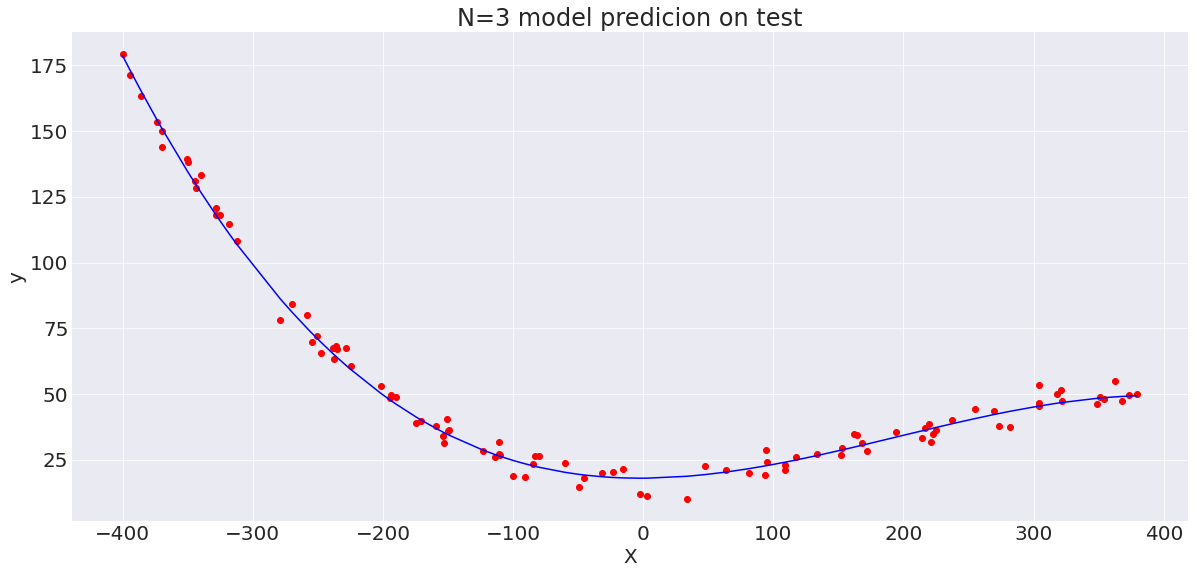

In [94]:
x_test_sort=np.sort(X_test)
y_test_predicted=model_winner_n3.predict(x_test_sort)
plt.figure()
plt.plot(x_test_sort,y_test_predicted,color='blue')
plt.scatter(X_test,y_test,color='red')
plt.title('N=3 model predicion on test')
plt.xlabel('X')
plt.ylabel('y')

## Apartado 4

In [171]:
class BatchGradientDescentModel(BaseModel):
    """
    Modelo de aproximación con regresión afín a la lineal polinómica
    """
    model = None
    deg = None
    bias = None
    
    def __init__(self):
        pass
    
    def fit(self, X, y, deg=1, bias=True, lr=0.01, epochs=100, b=50, k=5):
        
        if len(X.shape)<2:
            X=X[:,np.newaxis]
            
        if bias:
            X=np.append(X, np.ones(shape=(X.shape[0],1)), axis = 1)
            
        # Particiono en dataset Train y Valid
        chunk_size = round(X.shape[0] / k)
        x_valid = X[0: chunk_size]
        y_valid = y[0: chunk_size]
        x_train = X[chunk_size:]
        y_train = y[chunk_size:]
    
        m = x_train.shape[1]

        # initialize random weights
        W = np.zeros(shape=(m, 1),dtype='float64')
        
        train_errors=[]
        valid_errors=[]
        mse = MSE()

        # iterate over the n_epochs
        for i in range(epochs):

            # Shuffle all the samples 
            idx = np.random.permutation(x_train.shape[0])
            x_train = x_train[idx]
            y_train = y_train[idx]

            # Calculate the batch size in samples as a function of the number of batches
            batch_size = int(len(x_train) / b)

            # Iterate over the batches
            for i in range(0, len(x_train), batch_size):

                end = i + batch_size if i + batch_size <= len(x_train) else len(x_train)
                batch_X = x_train[i: end] # batch_size*m
                batch_y = y_train[i: end] # batch_size*1

                # Calculate the prediction for the whole batch
                prediction = batch_X@W  # batch_sizex1
                # Calculate the error for the whole batch
                error = batch_y - prediction[:,0]  # batch_sizex1

                # Calculate the gradient for the batch

                # error[batch_sizex1]*batch_X[batch_size*m]--> broadcasting --> batch_size*m
                grad_sum = np.sum(error[:,np.newaxis]* batch_X, axis=0) # 1xm
                grad_mul = -2/batch_size * grad_sum  # 1xm
                gradient = grad_mul[:,np.newaxis]  # mx1

                # Update the weights
                W = W - (lr * gradient)
            
            y_train_predictions = x_train@W 
            y_valid_predictions = x_valid@W
            train_errors.append(mse(y_train,y_train_predictions[:,0]))
            valid_errors.append(mse(y_valid,y_valid_predictions[:,0]))

        self.model=W
        self.bias=bias
        self.deg=deg
        return train_errors,valid_errors
    
    def predict(self,X):

        if len(X.shape)<2:
            X=X[:,np.newaxis]
            
        if self.bias:
            X=np.append(X, np.ones(shape=(X.shape[0],1)), axis = 1)
            
        y=X@self.model
        return y[:,0]

In [228]:
class ZScore():
    def __init__(self):
        pass
    
    def fit(self, x):
        self.mean = np.mean(x,axis=0)
        self.std = np.std(x,axis=0)
        
    def transform(self,x):
        x_norm=(x-self.mean)/self.std
        return x_norm

In [229]:
#Primero debemos escalar los datos
X_aux = X_train.copy()
for i in range(2,4):
    X_aux=np.vstack([X_aux,X_train**i])
X_aux=X_aux.transpose()
scaler = ZScore()
scaler.fit(X_aux)
X_train_std=scaler.transform(X_aux)

In [230]:
model_batch=BatchGradientDescentModel()
train_errors,valid_errors = model_batch.fit(X_train_std, y_train,3)

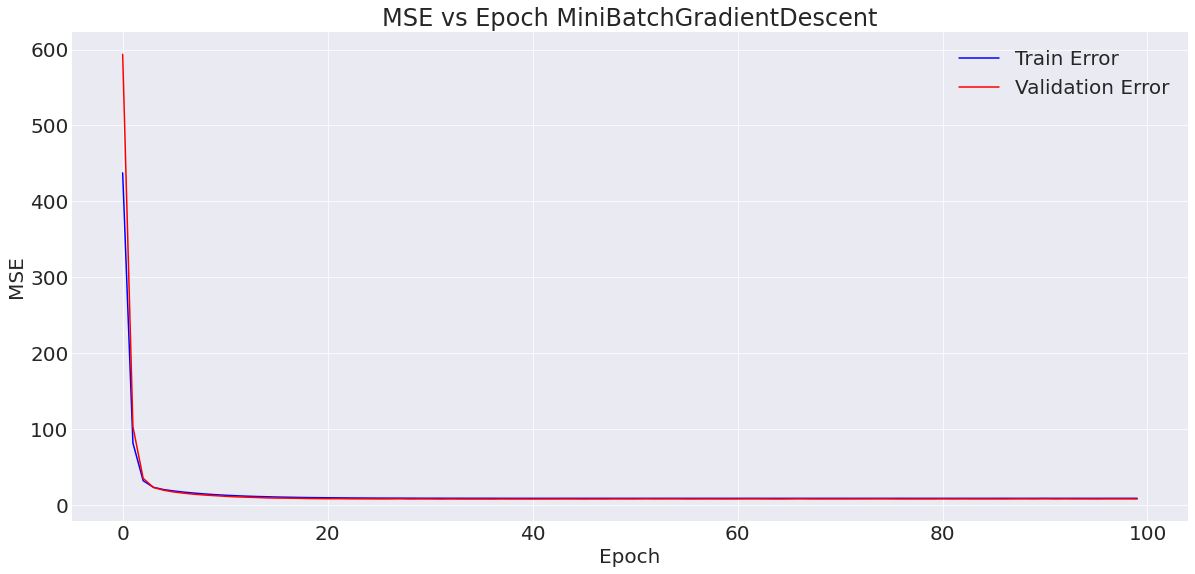

In [231]:
plt.figure()
plt.plot(train_errors,label='Train Error',color='blue')
plt.plot(valid_errors,label='Validation Error',color='red')
plt.title("MSE vs Epoch MiniBatchGradientDescent")
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

Se observa que el modelo converge rapidamente a la solución. Chequeamos cuales fueron los ultimos errores vistos y el error de test

In [232]:
print('Last Train error: ',train_errors[-1])
print('Last Validation error: ',valid_errors[-1])

Last Train error:  9.055049246998236
Last Validation error:  8.281409291481662


In [234]:
X_aux = X_test.copy()
for i in range(2,4):
    X_aux=np.vstack([X_aux,X_test**i])
X_aux=X_aux.transpose()
X_test_std=scaler.transform(X_aux)
y_test_predicted=model_batch.predict(X_test_std)
print('MSE Test Batch model: ',mse(y_test,y_test_predicted))

MSE Test Batch model:  11.77849263809673


Observamos que el MSE obtenido es prácticamente el mismo que el obtenido mediante solución cerrada

## Apartado 5

In [215]:
class RidgeBatchGradientDescentModel(BaseModel):
    """
    Modelo de aproximación con regresión afín a la lineal polinómica
    """
    model = None
    deg = None
    bias = None
    
    def __init__(self):
        pass
    
    def fit(self, X, y, deg=1, bias=True, lr=0.01, epochs=1000, b=50, alpha=0.001, k=5):
        
        if len(X.shape)<2:
            X=X[:,np.newaxis]
            
        if bias:
            X=np.append(X, np.ones(shape=(X.shape[0],1)), axis = 1)
            
        # Particiono en dataset Train y Valid
        chunk_size = round(X.shape[0] / k)
        x_valid = X[0: chunk_size]
        y_valid = y[0: chunk_size]
        x_train = X[chunk_size:]
        y_train = y[chunk_size:]
    
        m = x_train.shape[1]

        # initialize random weights
        W = np.zeros(shape=(m, 1),dtype='float64')
        
        train_errors=[]
        valid_errors=[]
        mse = MSE()

        # iterate over the n_epochs
        for i in range(epochs):

            # Shuffle all the samples 
            idx = np.random.permutation(x_train.shape[0])
            x_train = x_train[idx]
            y_train = y_train[idx]

            # Calculate the batch size in samples as a function of the number of batches
            batch_size = int(len(x_train) / b)

            # Iterate over the batches
            for i in range(0, len(x_train), batch_size):

                end = i + batch_size if i + batch_size <= len(x_train) else len(x_train)
                batch_X = x_train[i: end] # batch_size*m
                batch_y = y_train[i: end] # batch_size*1

                # Calculate the prediction for the whole batch
                prediction = batch_X@W  # batch_sizex1
                # Calculate the error for the whole batch
                error = batch_y - prediction[:,0]  # batch_sizex1

                # Calculate the gradient for the batch

                # error[batch_sizex1]*batch_X[batch_size*m]--> broadcasting --> batch_size*m
                grad_sum = np.sum(error[:,np.newaxis]* batch_X, axis=0) # 1xm
                grad_mul = -2/batch_size * grad_sum  # 1xm
                gradient = grad_mul[:,np.newaxis] + (2 * alpha *  np.sum(np.power(W,2)))

                # Update the weights
                W = W - (lr * gradient)
            
            y_train_predictions = x_train@W 
            y_valid_predictions = x_valid@W
            train_errors.append(mse(y_train,y_train_predictions[:,0]))
            valid_errors.append(mse(y_valid,y_valid_predictions[:,0]))

        self.model=W
        self.bias=bias
        self.deg=deg
        return train_errors,valid_errors
    
    def predict(self,X):

        if len(X.shape)<2:
            X=X[:,np.newaxis]
            
        if self.bias:
            X=np.append(X, np.ones(shape=(X.shape[0],1)), axis = 1)
            
        y=X@self.model
        return y[:,0]

In [236]:
#Primero debemos escalar los datos
X_aux = X_train.copy()
for i in range(2,4):
    X_aux=np.vstack([X_aux,X_train**i])
X_aux=X_aux.transpose()
scaler = ZScore()
scaler.fit(X_aux)
X_train_std=scaler.transform(X_aux)

In [237]:
model_ridge_batch=RidgeBatchGradientDescentModel()
train_errors,valid_errors = model_ridge_batch.fit(X_train_std, y_train,3)

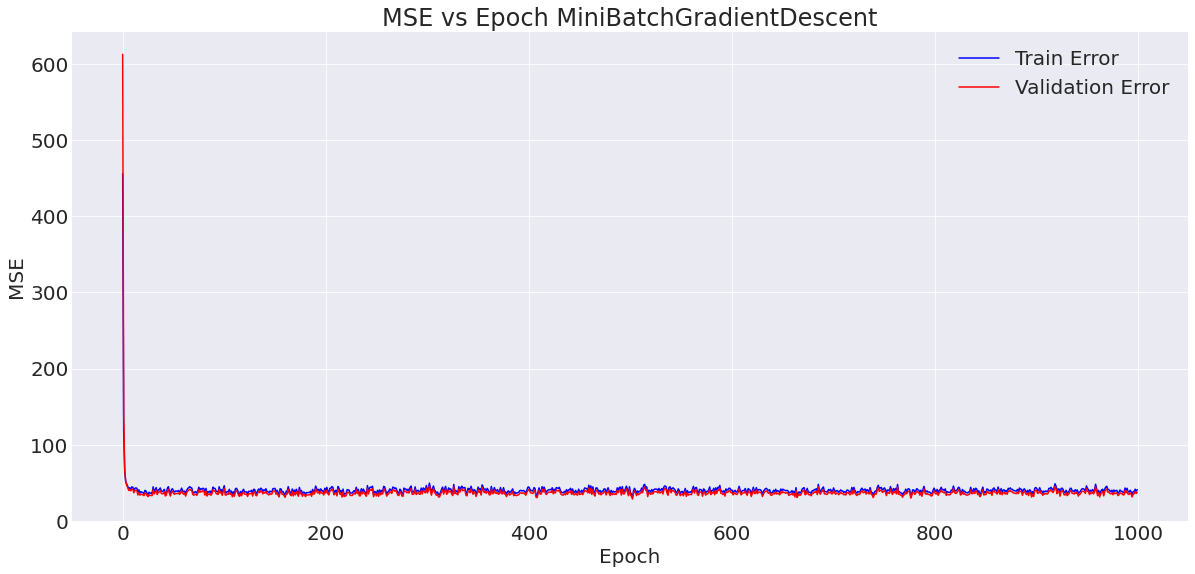

In [238]:
plt.figure()
plt.plot(train_errors,label='Train Error',color='blue')
plt.plot(valid_errors,label='Validation Error',color='red')
plt.title("MSE vs Epoch MiniBatchGradientDescent")
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

In [240]:
print('Last Train error: ',train_errors[-1])
print('Last Validation error: ',valid_errors[-1])

Last Train error:  41.28182409046796
Last Validation error:  37.99820606565034


Observamos en este caso que el error es mucho peor que en el caso anterior, esto se debe al efecto que produce la regularización Ridge al intentar mantener los parámetros con valor bajo. Lo que podemos hacer es disminuir el valor alpha de la regularizacion Ridge

In [241]:
model_ridge_batch=RidgeBatchGradientDescentModel()
train_errors,valid_errors = model_ridge_batch.fit(X_train_std, y_train,3, bias=True, lr=0.01, \
                                                  epochs=1000, b=50, alpha=0.0001, k=5)

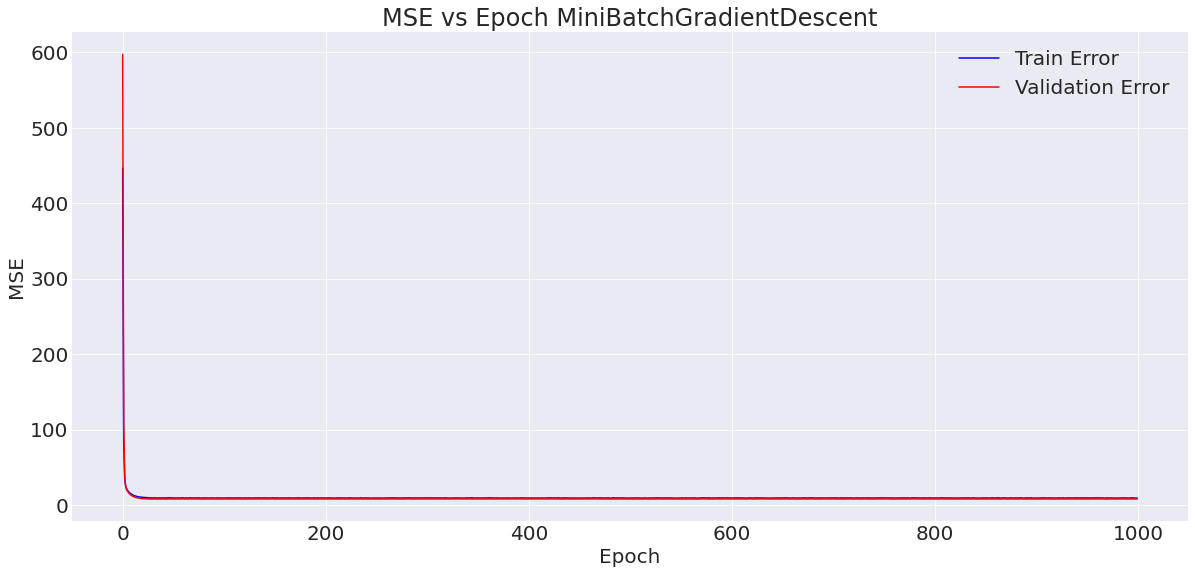

In [242]:
plt.figure()
plt.plot(train_errors,label='Train Error',color='blue')
plt.plot(valid_errors,label='Validation Error',color='red')
plt.title("MSE vs Epoch MiniBatchGradientDescent")
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

In [243]:
print('Last Train error: ',train_errors[-1])
print('Last Validation error: ',valid_errors[-1])

Last Train error:  9.446182711738553
Last Validation error:  8.206827626425362


En este caso observamos una performance reducida en Entrenamiento, ligeramente mejor en Validación respecto a MiniBatch. Finalmente chequeamos en Test

In [244]:
X_aux = X_test.copy()
for i in range(2,4):
    X_aux=np.vstack([X_aux,X_test**i])
X_aux=X_aux.transpose()
X_test_std=scaler.transform(X_aux)
y_test_predicted=model_ridge_batch.predict(X_test_std)
print('MSE Test Batch model: ',mse(y_test,y_test_predicted))

MSE Test Batch model:  12.403203996996952
